In [59]:
import numpy as np
import json
import warnings
import operator

import h5py
from keras.models import model_from_json
from keras import backend as K

from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

size_title = 18
size_label = 14
n_pred = 2

base_path = "data/remote_usage_wt_sample_wt/"

path_data_dict = base_path + "data_dict.txt"
path_inverted_wt = base_path + "inverted_weights.txt"
path_usage_wt = base_path + "usage_prediction.txt"
path_class_wt = base_path + "class_weights.txt"
path_test_data = base_path + "test_paths_dict.txt"
model_path = base_path + "trained_model.hdf5"

def read_file(file_path):
    with open(file_path, 'r') as data_file:
        data = json.loads(data_file.read())
    return data

class_weights = read_file(path_class_wt)
usage_weights = read_file(path_usage_wt)
inverted_weights = read_file(path_inverted_wt)
data_dict = read_file(path_data_dict)

def create_model(model_path):
    trained_model = h5py.File(model_path, 'r')
    model_config = json.loads(trained_model.get('model_config').value)
    loaded_model = model_from_json(model_config)
    dictionary = json.loads(trained_model.get('data_dictionary').value)
    compatibile_tools = json.loads(trained_model.get('compatible_tools').value)
    reverse_dictionary = dict((str(v), k) for k, v in dictionary.items())
    model_weights = list()
    weight_ctr = 0
    while True:
        try:
            d_key = "weight_" + str(weight_ctr)
            weights = trained_model.get(d_key).value
            model_weights.append(weights)
            weight_ctr += 1
        except Exception as exception:
            break
    # set the model weights
    loaded_model.set_weights(model_weights)
    return loaded_model, dictionary, reverse_dictionary, compatibile_tools

model, dictionary, reverse_dictionary, compatibile_tools = create_model(model_path)

In [60]:
reverse_dictionary

{'1': 'shovill',
 '2': 'limma_voom',
 '3': 'FileInfo',
 '4': 'vcfselectsamples',
 '5': 'numeric_clustering',
 '6': 'get_sequences',
 '7': 'xcms_merge',
 '8': 'MapRTTransformer',
 '9': 'samtools_slice_bam',
 '10': 'ctb_simsearch',
 '11': 'bg_find_subsequences',
 '12': 'gmx_nvt',
 '13': 'addValue',
 '14': 'qiime_pick_closed_reference_otus',
 '15': 'cardinal_data_exporter',
 '16': 'tab2fasta',
 '17': 'tp_tac',
 '18': 'gspan',
 '19': 'cshl_awk_replace_in_column',
 '20': 'mass_spectrometry_imaging_filtering',
 '21': 'thermo_raw_file_converter',
 '22': 'infernal_cmstat',
 '23': 'mass_spectrometry_imaging_classification',
 '24': 'cshl_fasta_nucleotides_changer',
 '25': 'dbbuilder',
 '26': 'Count1',
 '27': 'msgfplus',
 '28': 'mothur_make_group',
 '29': 'bamFilter',
 '30': 'MapStatistics',
 '31': 'deeptools_plot_heatmap',
 '32': 'gemini_interactions',
 '33': 'deeptools_bigwigCompare',
 '34': 'deeptools_bamFingerprint',
 '35': 'flexbar_split_RR_bcs',
 '36': 'infernal_cmbuild',
 '37': 'picard_Col

In [80]:
def verify_model(model, tool_sequence, labels, dictionary, reverse_dictionary, compatible_tools, topk=10, max_seq_len=25):
    tl_seq = tool_sequence.split(",")
    last_tool_name = reverse_dictionary[str(tl_seq[-1])]
    try:
        labels_split = labels.split(",")
        label_names = [reverse_dictionary[str(tool_pos)] for tool_pos in labels_split]
    except:
        labels_split = list()
        label_names = []
        pass
    topk = len(labels_split)
    last_compatible_tools = compatible_tools[last_tool_name]
    sample = np.zeros(max_seq_len)
    for idx, tool_id in enumerate(tl_seq):
        sample[idx] = int(tool_id)
    sample_reshaped = np.reshape(sample, (1, max_seq_len))
    
    tool_sequence_names = [reverse_dictionary[str(tool_pos)] for tool_pos in tool_sequence.split(",")]
    #print(",".join(tool_sequence_names))
    # predict next tools for a test path
    prediction = model.predict(sample_reshaped, verbose=0)
    prediction = np.reshape(prediction, (prediction.shape[1],))
    prediction_pos = np.argsort(prediction, axis=-1)

    # get topk prediction
    topk_prediction_pos = prediction_pos[-topk:]
    topk_prediction_val = [np.round(prediction[pos] * 100, 2) for pos in topk_prediction_pos]

    # read tool names using reverse dictionary
    pred_tool_ids = [reverse_dictionary[str(tool_pos)] for tool_pos in topk_prediction_pos]
    actual_next_tool_ids = list(set(pred_tool_ids).intersection(set(last_compatible_tools.split(","))))      
        
    #print("Predicted tools: %s" % ",".join(pred_tool_ids))
    #print()
    pred_tool_ids_sorted = dict()
    for (tool_pos, tool_pred_val) in zip(topk_prediction_pos, topk_prediction_val):
        tool_name = reverse_dictionary[str(tool_pos)]
        if tool_name in actual_next_tool_ids:
            pred_tool_ids_sorted[tool_name] = tool_pred_val
    pred_tool_ids_sorted = dict(sorted(pred_tool_ids_sorted.items(), key=lambda kv: kv[1], reverse=True))
    
    cls_wt = dict()
    usg_wt = dict()
    inv_wt = dict()
    ids_tools = dict()
    keys = list(pred_tool_ids_sorted.keys())
    for k in keys:
        try:
            cls_wt[k] = np.round(class_weights[str(data_dict[k])], 2)
            usg_wt[k] = np.round(usage_weights[k], 2)
            inv_wt[k] = np.round(inverted_weights[str(data_dict[k])], 2)
        except:
            continue
    #print("Predicted tools: \n")
    #print(pred_tool_ids_sorted)
    #print()
    #print("Class weights: \n")
    cls_wt = dict(sorted(cls_wt.items(), key=lambda kv: kv[1], reverse=True))
    #print(cls_wt)
    #print()
    #print("Usage weights: \n")
    usg_wt = dict(sorted(usg_wt.items(), key=lambda kv: kv[1], reverse=True))
    #print(usg_wt)
    #print()
    #print("Inverted weights: \n")
    inv_wt = dict(sorted(inv_wt.items(), key=lambda kv: kv[1], reverse=True))
    #print(inv_wt)
    for key in pred_tool_ids_sorted:
        ids_tools[key] = dictionary[key]
    #print()
    #print(ids_tools)
    #print("======================================")
    ave_pred_wt = np.mean(list(pred_tool_ids_sorted.values()))
    ave_cls_wt = np.mean(list(cls_wt.values()))
    ave_inv_wt = np.mean(list(inv_wt.values()))
    ave_usg_wt = 0
    #print(len(list(usg_wt.values())))
    if len(list(usg_wt.values())) > 0:
        ave_usg_wt = np.mean(list(usg_wt.values()))
    
    # find false positives
    false_positives = [ tool_name for tool_name in pred_tool_ids if tool_name not in label_names ]
    absolute_precision = 1 - ( len( false_positives ) / float( len( label_names ) ) )
    ave_abs_precision.append(absolute_precision)
    compatible_fp = [ tool_name for tool_name in pred_tool_ids if tool_name not in actual_next_tool_ids ]
    compatible_precision = 1 - ( len( compatible_fp ) / float( len( label_names ) ) )
    ave_comp_precision.append(compatible_precision)
    
    '''print()
    print("True labels: %s" % ",".join(label_names))
    print("Predicted labels: %s" % ",".join(pred_tool_ids))
    print("False labels: %s" % ",".join(false_positives))
    print("False incompatible labels: %s" % ",".join(compatible_fp))
    print()'''
    
    #print("Absolute precision on test data using current model is: %0.6f" % absolute_precision)
    #print("Compatible precision on test data using current model is: %0.6f" % compatible_precision)
    length = len(tool_sequence_names)
    if length not in precision_path_length:
        precision_path_length[length] = list()
    precision_path_length[length].append(absolute_precision)
    #print("----------------------------")
    return ave_pred_wt, ave_cls_wt, ave_usg_wt, ave_inv_wt

ave_prediction_weights = list()
ave_class_weights = list()
ave_usage_weights = list()
ave_inverted_weights = list()

ave_abs_precision = list()
ave_comp_precision = list()
precision_path_length = dict()
def get_predictions(model, dictionary, reverse_dictionary, compatibile_tools):
    t_data = read_file(path_test_data)
    ctr = 1
    for ph, cl in t_data.items():
        ave_pred_wt, ave_cls_wt, ave_usg_wt, ave_inv_wt = verify_model(model, ph, cl, dictionary, reverse_dictionary, compatibile_tools)
        ave_prediction_weights.append(ave_pred_wt)
        ave_class_weights.append(ave_cls_wt)
        ave_usage_weights.append(ave_usg_wt)
        ave_inverted_weights.append(ave_inv_wt)
        ctr += 1
        if ctr == 10000:
            break

get_predictions(model, dictionary, reverse_dictionary, compatibile_tools)
print("Mean abs precision on test data using current model is: %0.6f" % np.mean(ave_abs_precision))
print("Mean abs precision on test data using current model is: %0.6f" % np.mean(ave_comp_precision))

Mean abs precision on test data using current model is: 0.979552
Mean abs precision on test data using current model is: 0.988945


999
155.70192933409598


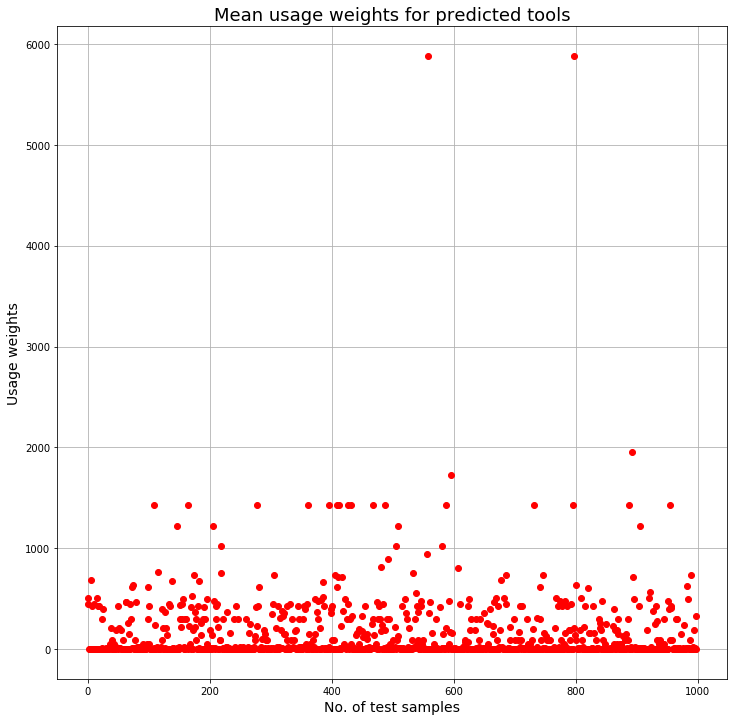

In [79]:
def plot_hist(x_val1, title, xlabel, ylabel):

    plt.figure(figsize=(12, 12))
    x_pos = np.arange(len(x_val1))
    plt.plot(x_pos, x_val1, 'ro')
    plt.xlabel(xlabel, size=size_label)
    plt.ylabel(ylabel, size=size_label)
    plt.title(title, size=size_title)
    plt.grid(True)
    plt.show()

print(len(ave_usage_weights))
print(np.mean(ave_usage_weights))
with open(base_path + "predicted_tools_usage.txt", 'w+') as fl:
    fl.write(str(ave_usage_weights))
plot_hist(ave_usage_weights, "Mean usage weights for predicted tools", "No. of test samples", "Usage weights")


def plot_scatter(x_val, y_val, title, xlabel, ylabel):
    plt.figure(figsize=(8, 8))
    plt.plot(x_val, y_val, 'ro')
    plt.xlabel(xlabel, size=size_label)
    plt.ylabel(ylabel, size=size_label)
    plt.title(title, size=size_title)
    plt.grid(True)
    plt.show()

#plot_scatter(ave_prediction_weights, ave_class_weights, "Prediction vs class weights", "Prediction scores", "Class weights")
#plot_scatter(ave_prediction_weights, ave_usage_weights, "Prediction vs usage weights", "Prediction scores", "Usage weights")
#plot_scatter(ave_prediction_weights, ave_inverted_weights, "Prediction vs inverted weights", "Prediction scores", "Inverted weights")

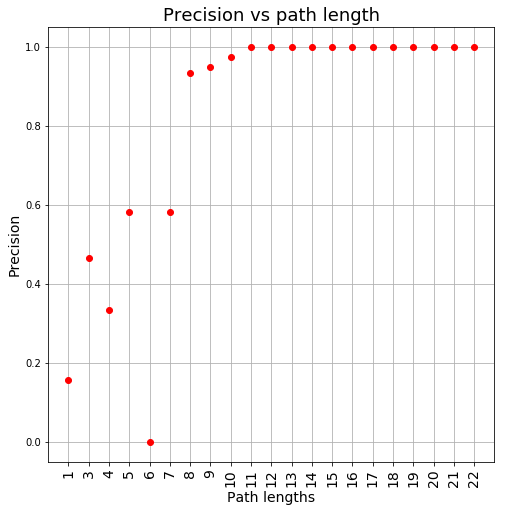

In [74]:
import collections


lengths = list()
mean_precision = list()

precision_path_length_ordered = dict(collections.OrderedDict(sorted(precision_path_length.items())))

for length in precision_path_length_ordered:
    lengths.append(length)
    mean_precision.append(np.mean(precision_path_length[length]))
    
def plot_hist(x_val, y_val, title, xlabel, ylabel):

    plt.figure(figsize=(8, 8))
    x_pos = np.arange(len(y_val))
    plt.plot(x_pos, y_val, 'ro')
    plt.xticks(range(len(x_val)), x_val, size=size_label, rotation='vertical')
    plt.xlabel(xlabel, size=size_label)
    plt.ylabel(ylabel, size=size_label)
    plt.title(title, size=size_title)
    plt.grid(True)
    plt.show()
    
plot_hist(lengths, mean_precision, "Precision vs path length", "Path lengths", "Precision")